# 신경망 구현과 학습

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

## 스파이럴 데이터셋

In [2]:
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데이터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))  # (300,2)
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)  #(300,3)

    for j in range(CLS_NUM): # 3회 반복
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [3]:
x, t = load_data()
print('x: ', x.shape)  # (300, 2)
print('t: ', t.shape)  # (300, 3) , one-hot encoding

x:  (300, 2)
t:  (300, 3)


In [4]:
x

array([[-0.00000000e+00,  0.00000000e+00],
       [-9.76986432e-04,  9.95216044e-03],
       [ 5.12668241e-03,  1.93317647e-02],
       [-3.86043324e-04,  2.99975161e-02],
       [ 1.42509650e-02,  3.73752591e-02],
       [ 9.41914082e-04,  4.99911272e-02],
       [ 2.25361319e-02,  5.56068589e-02],
       [ 6.52848904e-03,  6.96948982e-02],
       [ 2.50649535e-02,  7.59720219e-02],
       [ 2.03287580e-02,  8.76740646e-02],
       [ 5.98440862e-02,  8.01166983e-02],
       [ 6.19050693e-02,  9.09272368e-02],
       [ 3.22809763e-02,  1.15576549e-01],
       [ 8.28423530e-02,  1.00185551e-01],
       [ 1.09856959e-01,  8.67839183e-02],
       [ 9.33208222e-02,  1.17436043e-01],
       [ 7.82976217e-02,  1.39533087e-01],
       [ 1.23994559e-01,  1.16298535e-01],
       [ 8.06199110e-02,  1.60936105e-01],
       [ 1.39235917e-01,  1.29280158e-01],
       [ 1.53599653e-01,  1.28090384e-01],
       [ 1.38981638e-01,  1.57429680e-01],
       [ 1.89873275e-01,  1.11122183e-01],
       [ 1.

In [5]:
t

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [6]:
# pandas DataFrame으로 출력
import pandas as pd
df = pd.DataFrame(x)
df['label'] = np.argmax(t,1)  # axis=1 (수평방향)
print(df['label'].value_counts())
df

2    100
1    100
0    100
Name: label, dtype: int64


,0,1,label
0,-0.000000,0.000000,0
1,-0.000977,0.009952,0
2,0.005127,0.019332,0
3,-0.000386,0.029998,0
4,0.014251,0.037375,0
...,...,...,...
295,-0.456406,0.833183,2
296,-0.630263,0.724133,2
297,-0.575706,0.780681,2
298,-0.206075,0.958088,2


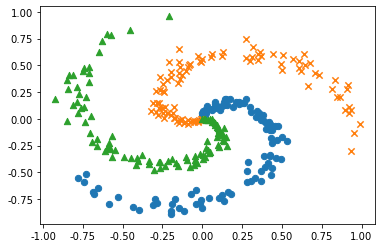

In [7]:
# 데이터 점 플롯
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
# plt.rc('font', family='Malgun Gothic')
for i in range(3):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## 신경망 모델 구현

In [8]:
from nn_layers import Sigmoid, Affine, SoftmaxWithLoss, SGD

class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size) :
        I,H,O = input_size,hidden_size,output_size
        
        # 가중치와 편향 초기화
        W1 = 0.01 * np.random.randn(I,H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H,O)
        b2 = np.zeros(O)        
        
        # 계층 생성
        self.layers = [
            Affine(W1,b1),
            Sigmoid(),
            Affine(W2,b2)
        ]
        
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기(미분)를 리스트에 모은다
        self.params, self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    # 예측        
    def predict(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    # 순전파 학습
    def forward(self,x,t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score,t)
        return loss
                
    # 역전파 학습
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

[[0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]] (1, 8)
----------------------------------------------------------------------
[[0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]
 [0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]
 [0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]
 [0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]
 [0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]
 [0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]
 [0.95159062 0.69972154 0.86946239 0.78121336 0.50754295 0.25867898
  0.21907473 0.27661317]] (7, 8)
[[0.54629033 0.47536075 0.79484065 0.50796807 0.32285642 0.12750487
  0.45865915 0.9640462 ]
 [0.90788016 0.18299938 0.08008617 0.08177361 0.06057029 0.88125356
  0.0575

In [9]:
a = [1,2,3]
for k in reversed(a): # Return a reverse iterator over the values of the given sequence.
    print(k)          # 요소의 순서를 거꾸로 변경

3
2
1


## 학습 코드

In [10]:
# 하이퍼 파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 데이터  읽기
x, t = load_data()

# 모델 객체 생성
model = TwoLayerNet(input_size=2,hidden_size=hidden_size,output_size=3)

# 옵티마이저 생성
optimizer = SGD(lr=learning_rate)
# optimizer = Adam(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)  # 300개
max_iters = data_size // batch_size # 10, 정수 몫, for문에서 사용
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch): # 300회
    
    # 데이터 뒤섞기
    idx = np.random.permutation(data_size)   
    x = x[idx]
    t = t[idx]
    
    for iters in range(max_iters): # 10회
        batch_x = x[iters*batch_size:(iters+1)*batch_size]  # 30개 씩 추출
        batch_t = t[iters*batch_size:(iters+1)*batch_size]
        
        # 순전파와 역전파를 수행 매개변수를 갱신
        loss = model.forward(batch_x,batch_t)
        model.backward()
        optimizer.update(model.params,model.grads)
        
        total_loss += loss
        loss_count += 1
        
        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| epoch: %d |  반복 %d / %d | loss: %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0

| epoch: 1 |  반복 10 / 10 | loss: 1.13
| epoch: 2 |  반복 10 / 10 | loss: 1.13
| epoch: 3 |  반복 10 / 10 | loss: 1.12
| epoch: 4 |  반복 10 / 10 | loss: 1.12
| epoch: 5 |  반복 10 / 10 | loss: 1.11
| epoch: 6 |  반복 10 / 10 | loss: 1.14
| epoch: 7 |  반복 10 / 10 | loss: 1.16
| epoch: 8 |  반복 10 / 10 | loss: 1.11
| epoch: 9 |  반복 10 / 10 | loss: 1.12
| epoch: 10 |  반복 10 / 10 | loss: 1.13
| epoch: 11 |  반복 10 / 10 | loss: 1.12
| epoch: 12 |  반복 10 / 10 | loss: 1.11
| epoch: 13 |  반복 10 / 10 | loss: 1.09
| epoch: 14 |  반복 10 / 10 | loss: 1.08
| epoch: 15 |  반복 10 / 10 | loss: 1.04
| epoch: 16 |  반복 10 / 10 | loss: 1.03
| epoch: 17 |  반복 10 / 10 | loss: 0.96
| epoch: 18 |  반복 10 / 10 | loss: 0.92
| epoch: 19 |  반복 10 / 10 | loss: 0.92
| epoch: 20 |  반복 10 / 10 | loss: 0.87
| epoch: 21 |  반복 10 / 10 | loss: 0.85
| epoch: 22 |  반복 10 / 10 | loss: 0.82
| epoch: 23 |  반복 10 / 10 | loss: 0.79
| epoch: 24 |  반복 10 / 10 | loss: 0.78
| epoch: 25 |  반복 10 / 10 | loss: 0.82
| epoch: 26 |  반복 10 / 10 | loss: 

| epoch: 245 |  반복 10 / 10 | loss: 0.13
| epoch: 246 |  반복 10 / 10 | loss: 0.13
| epoch: 247 |  반복 10 / 10 | loss: 0.13
| epoch: 248 |  반복 10 / 10 | loss: 0.13
| epoch: 249 |  반복 10 / 10 | loss: 0.13
| epoch: 250 |  반복 10 / 10 | loss: 0.13
| epoch: 251 |  반복 10 / 10 | loss: 0.13
| epoch: 252 |  반복 10 / 10 | loss: 0.12
| epoch: 253 |  반복 10 / 10 | loss: 0.12
| epoch: 254 |  반복 10 / 10 | loss: 0.12
| epoch: 255 |  반복 10 / 10 | loss: 0.12
| epoch: 256 |  반복 10 / 10 | loss: 0.12
| epoch: 257 |  반복 10 / 10 | loss: 0.12
| epoch: 258 |  반복 10 / 10 | loss: 0.12
| epoch: 259 |  반복 10 / 10 | loss: 0.13
| epoch: 260 |  반복 10 / 10 | loss: 0.12
| epoch: 261 |  반복 10 / 10 | loss: 0.13
| epoch: 262 |  반복 10 / 10 | loss: 0.12
| epoch: 263 |  반복 10 / 10 | loss: 0.12
| epoch: 264 |  반복 10 / 10 | loss: 0.13
| epoch: 265 |  반복 10 / 10 | loss: 0.12
| epoch: 266 |  반복 10 / 10 | loss: 0.12
| epoch: 267 |  반복 10 / 10 | loss: 0.12
| epoch: 268 |  반복 10 / 10 | loss: 0.12
| epoch: 269 |  반복 10 / 10 | loss: 0.11


In [11]:
np.random.permutation(10) # # 0에서 9까지의 무작위 순서를 생성해서 반환

array([5, 1, 8, 4, 9, 7, 0, 2, 6, 3])

In [12]:
# 학습으로 얻어진 Weight과 bias
model.params

[array([[ -2.1607114 ,  -2.06001261,   6.2644703 , -12.98640329,
          -6.9466837 ,  -2.28468984,   9.1615864 ,   0.47703812,
          -3.83769718,   4.59998052],
        [ -5.34161945,  -2.07459244,   0.66955144,   8.79977163,
           4.6694405 ,   1.47503494,   4.31423356, -10.96295609,
          -9.20341831,  -0.77300896]]),
 array([-2.70396582, -1.13018315, -0.465546  , -0.25301975, -4.19274811,
        -0.4693508 , -5.06685239, -4.89562826, -0.61899928, -0.41780938]),
 array([[ 4.29580023, -4.19650113, -0.10506222],
        [ 1.50279722, -3.01229382,  1.52780646],
        [ 3.96246928, -1.23014656, -2.74592256],
        [ 0.94111788,  7.67867863, -8.63384161],
        [-3.34578484, -4.70084489,  8.03712461],
        [-2.02464691, -1.10989888,  3.12667305],
        [-6.50482205,  8.82244683, -2.30968047],
        [ 9.81602267, -4.26370529, -5.59278734],
        [-7.2620981 ,  0.84615918,  6.40020623],
        [ 3.17287788, -0.45134309, -2.68410624]]),
 array([-0.37217883, -

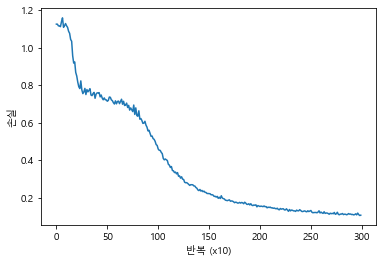

In [13]:
# 학습 결과 플롯
plt.rc('font', family='Malgun Gothic')
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('반복 (x10)')
plt.ylabel('손실')
plt.show()

[[-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 ...
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]]
--------------------------------------------------------------------------------
[[-0.98867266 -0.98867266 -0.98867266 ... -0.98867266 -0.98867266
  -0.98867266]
 [-0.98767266 -0.98767266 -0.98767266 ... -0.98767266 -0.98767266
  -0.98767266]
 [-0.98667266 -0.98667266 -0.98667266 ... -0.98667266 -0.98667266
  -0.98667266]
 ...
 [ 1.05532734  1.05532734  1.05532734 ...  1.05532734  1.05532734
   1.05532734]
 [ 1.05632734  1.05632734  1.05632734 ...  1.05632734  1.05632734
   1.05632734]
 [ 1.05732734  1.05732734  1.05732734 ...  1.05732734  1.05732734

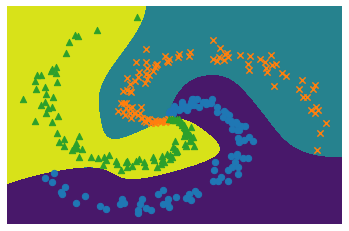

In [14]:
# 경계 영역 플롯 : Decision Boundary(결정 경계)
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
print(xx)
print('-'*80)
print(yy)
print('-'*80)

X = np.c_[xx.ravel(), yy.ravel()]
print(X)

score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)  # 예측 값
plt.contourf(xx, yy, Z)
plt.axis('off')  # x,y 축 표시 없앰

# 데이터점 플롯
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [15]:
# meshgrid() : x 값의 배열과 y 값의 배열로 직사각형 격자행렬을 만든다

xval = np.array([0, 1, 2, 3, 4]);
yval = np.array([0, 1, 2, 3, 4]);

x, y = np.meshgrid(xval, yval)
x, y


# x[0,0] = 0    y[0,0] = 0
# x[0,1] = 1    y[0,1] = 0
# x[0,2] = 2    y[0,2] = 0
# x[0,3] = 3    y[0,3] = 0
# x[0,4] = 4    y[0,4] = 0
# x[1,0] = 0    y[1,0] = 1
# x[1,1] = 1    y[1,1] = 1
# ...
# x[4,3] = 3    y[4,3] = 4
# x[4,4] = 4    y[4,4] = 4

# x =   0 1 2 3 4        y =   0 0 0 0 0
#       0 1 2 3 4              1 1 1 1 1
#       0 1 2 3 4              2 2 2 2 2
#       0 1 2 3 4              3 3 3 3 3
#       0 1 2 3 4              4 4 4 4 4

(array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]]))

In [16]:
#  ravel() : ravel은 "풀다"로 다차원을 1차원으로 푸는 것을 의미한다
a1 = np.array([[1,2],
               [3,4]])
a2 = a1.ravel() # 또는 a2 = a1.reshape(-1) 또는 a2 = a1.flatten()
a2

array([1, 2, 3, 4])

In [17]:
# np.c_[]  : 두 개의 1차원 배열을 칼럼으로 세로로 붙여서 2차원 배열 만들기
# https://rfriend.tistory.com/352

a = np.array([1,2,3])
b = np.array([4,5,6])
c = np.c_[a,b]
c

array([[1, 4],
       [2, 5],
       [3, 6]])

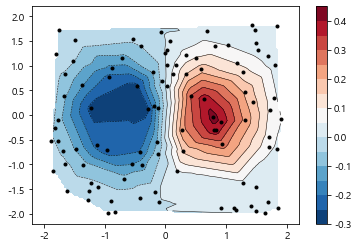

In [18]:
# plt.contourf() : 등고선  플롯 , 경계를 채운다
# http://www.gisdeveloper.co.kr/?p=10192
# https://rfriend.tistory.com/547

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
npts = 100
x = np.random.uniform(-2, 2, npts)
y = np.random.uniform(-2, 2, npts)
z = x * np.exp(-x**2 - y**2)
ngridx = 100
ngridy = 100
xi = np.linspace(-2.2, 2.2, ngridx)
yi = np.linspace(-2.2, 2.2, ngridy)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)


plt.contour(xi, yi, zi, levels=15, linewidths=0.5, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.plot(x, y, 'ko', ms=3)
plt.show()